In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import numpy
import pylab
import sys
import time
import seaborn
seaborn.set_style("darkgrid")
import geopy 
from geopy import *
from geopy.distance import vincenty
from __future__ import division
from gensim import corpora, models, similarities
from gensim.models import word2vec
import re
geolocator = Nominatim()
%matplotlib inline

dbname = 'meetup_db'
username = 'mamday'
pswd = 'gr8ndm8'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))

if not database_exists(engine.url):
    create_database(engine.url)

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

In [2]:
# Group Url join queries
sql_query = """
SELECT * FROM event_table WHERE group_url='seattleworldmusic';
"""
gurl_from_table = pd.read_sql_query(sql_query,con)

print 'Event',gurl_from_table[:2]

#Get all from wild card - Super useful
#sql_query = """
#SELECT * FROM group_table WHERE group_url LIKE '%seattleworldmusic%';
#"""

sql_query = """
SELECT * FROM group_table WHERE group_url='seattleworldmusic';
"""
gurl_from_table = pd.read_sql_query(sql_query,con)
print 'Group',gurl_from_table[:2]

sql_query = """
SELECT * FROM event_table, group_table WHERE event_table.group_url=group_table.group_url;
"""

joingurl_from_table = pd.read_sql_query(sql_query,con)
print 'Joined',joingurl_from_table[:2]

Event    evt_id                                            evt_url  \
0     448   http://www.meetup.com/seattleworldmusic/event...   
1     449   http://www.meetup.com/seattleworldmusic/event...   

               evt_name  fee  duration         date        time        lat  \
0   Fremont Drum Class    55         1   2016-06-12   14:30:00   47.652382   
1   Fremont Drum Class    55         1   2016-06-19   14:30:00   47.652382   

          lon          group_url  
0 -122.356155  seattleworldmusic  
1 -122.356155  seattleworldmusic  
Group    group_id          group_url                            group_name    topic
0        33  seattleworldmusic  The Seattle World Music Meetup Group  dancing
1      2705  seattleworldmusic  The Seattle World Music Meetup Group  dancing
Joined    evt_id                                            evt_url  \
0       0   http://www.meetup.com/seattle-witches/events/...   
1       0   http://www.meetup.com/seattle-witches/events/...   

             evt_name

In [3]:
# Evt ID join queries
sql_query = """
SELECT * FROM event_table;
"""
evtid_from_table = pd.read_sql_query(sql_query,con)

print 'Event Test',evtid_from_table[:2],'Length',len(evtid_from_table)

sql_query = """
SELECT * FROM search_table WHERE evt_id='22';
"""
evtid_from_table = pd.read_sql_query(sql_query,con)

print 'Search',evtid_from_table[:2]

sql_query = """
SELECT search_table.evt_url FROM event_table,search_table WHERE event_table.evt_id=search_table.evt_id;
"""
evtid_from_table = pd.read_sql_query(sql_query,con)
print 'Join',evtid_from_table["evt_url"][:2]

Event Test    evt_id                                            evt_url  \
0       0   http://www.meetup.com/seattle-witches/events/...   
1       1   http://www.meetup.com/seattle-witches/events/...   

             evt_name  fee  duration         date        time        lat  \
0   South End Social     0         2   2016-06-13   19:00:00   47.450455   
1            OLOTEAS     0        -1   2016-06-25   14:00:00   47.643410   

          lon        group_url  
0 -122.262047  seattle-witches  
1 -122.027524  seattle-witches   Length 66865
Search   index  evt_id                                            evt_url  nerd_score
0  None      22    http://www.meetup.com/seattle-witches/events...    0.020119
Join 0    http://www.meetup.com/seattle-witches/events/2...
1    http://www.meetup.com/seattle-witches/events/2...
Name: evt_url, dtype: object


In [4]:
sql_query = """
SELECT event_table.evt_url FROM event_table,newsearch_table WHERE event_table.evt_id=newsearch_table.evt_id;
"""
evtid_from_table = pd.read_sql_query(sql_query,con)
#print len(evtid_from_table["group_url"]),
#print len(evtid_from_table["group_url"][(evtid_from_table["nerd_score"]>0.1) & (evtid_from_table["nerd_score"]<0.2)])
test = evtid_from_table["evt_url"]
print len(test)

sql_query = """
SELECT * FROM event_table,newsearch_table WHERE event_table.evt_id=newsearch_table.evt_id
AND (newsearch_table.g_score>0.33 OR newsearch_table.e_score>0.29);
"""
evtid_from_table = pd.read_sql_query(sql_query,con)
#print len(evtid_from_table["group_url"]),
#print len(evtid_from_table["group_url"][(evtid_from_table["nerd_score"]>0.1) & (evtid_from_table["nerd_score"]<0.2)])
test = evtid_from_table["evt_url"]
print len(test)
#import webbrowser
#wb = webbrowser.get('chromium-browser')
#wb.open(evtid_from_table["evt_url"][0])

#print 'Join',evtid_from_table[:2]

66828
6909


In [5]:
imdb_model = word2vec.Word2Vec.load('/home/mamday/insight-project/HN_300features_40minwords_10context')
imdb_model.most_similar('nerd')


[(u'geek', 0.7940468192100525),
 (u'nerdy', 0.6233459711074829),
 (u'jock', 0.6111011505126953),
 (u'hipster', 0.5946129560470581),
 (u'stereotypical', 0.5784639120101929),
 (u'nerds', 0.5694308280944824),
 (u'geeky', 0.5616758465766907),
 (u'gamer', 0.5593466758728027),
 (u'bro', 0.5535667538642883),
 (u'douchebag', 0.5508331060409546)]

In [6]:
imdb_model.most_similar(positive=['nerd','geek','hobby'],negative=['person','person','social'])

[(u'hobbyist', 0.46869438886642456),
 (u'hardcore', 0.42264625430107117),
 (u'diy', 0.3980792164802551),
 (u'enthusiast', 0.3694038689136505),
 (u'nerdy', 0.3670386075973511),
 (u'retro', 0.36689066886901855),
 (u'geeky', 0.3649691045284271),
 (u'toy', 0.3524910807609558),
 (u'cyberpunk', 0.3470974862575531),
 (u'gamer', 0.34676265716552734)]

In [7]:
print sum(imdb_model['nerd']*imdb_model['nerdy'])

0.623346015123


In [8]:
def cos_sim(pmvec,vec2):
    pmvec = pmvec/numpy.sqrt(sum(pmvec*pmvec))
    return sum(pmvec*norm_vec(vec2))

In [9]:
def norm_vec(vec_text):
    vec = 300*[0]
    for v in vec_text:
        vec+=imdb_model[v]
    return vec/numpy.sqrt(sum(vec*vec))

In [10]:
#nerd_vec =(imdb_model['nerd']+imdb_model['geek']+imdb_model['activity']+imdb_model['hobby']-2*imdb_model['social']-3*imdb_model['person'])

hobby_vec =(imdb_model['nerd']+imdb_model['geek']+2*imdb_model['hobby']-2*imdb_model['person'])
#nerd_vec =(imdb_model['nerd']+imdb_model['geek']+2*imdb_model['writing']-2*imdb_model['person'])
#nerd_vec =(imdb_model['nerd']+imdb_model['geek']+imdb_model['activity']+imdb_model['hobby']-2*imdb_model['person'])
cos_sim(hobby_vec,['hobbyist','nerd','geek'])

0.6745906687964186

In [11]:
imdb_model.most_similar(topn=20,positive=['nerd','nerd','personality','personality'],negative=['person','person'])

[(u'geek', 0.5467638969421387),
 (u'nerdy', 0.5168413519859314),
 (u'stereotypical', 0.4978628158569336),
 (u'geeky', 0.4871760606765747),
 (u'macho', 0.4777027666568756),
 (u'jock', 0.46400174498558044),
 (u'hipster', 0.44571012258529663),
 (u'introverted', 0.43227291107177734),
 (u'narcissistic', 0.428775429725647),
 (u'bro', 0.4213663935661316),
 (u'brogrammer', 0.4193842113018036),
 (u'ocd', 0.4158487319946289),
 (u'introversion', 0.41408684849739075),
 (u'hardcore', 0.4107530415058136),
 (u'humor', 0.40365538001060486),
 (u'psychopathic', 0.40175509452819824),
 (u'masculine', 0.39801254868507385),
 (u'cyberpunk', 0.39475443959236145),
 (u'spiritual', 0.38916096091270447),
 (u'immaturity', 0.3879554569721222)]

In [12]:
imdb_model.most_similar(topn=20,positive=['nerd','geek','skill','skill'],negative=['person','person'])

[(u'skills', 0.4395788311958313),
 (u'hardcore', 0.425833523273468),
 (u'geeky', 0.41702380776405334),
 (u'nerdy', 0.38295745849609375),
 (u'maths', 0.3708479404449463),
 (u'mastery', 0.36944425106048584),
 (u'prowess', 0.362113893032074),
 (u'literacy', 0.3590790629386902),
 (u'programming', 0.35782569646835327),
 (u'aptitude', 0.35242629051208496),
 (u'wizardry', 0.3483026325702667),
 (u'hobbyist', 0.3478353023529053),
 (u'ambition', 0.34772294759750366),
 (u'hobby', 0.34619659185409546),
 (u'fluency', 0.34614187479019165),
 (u'entrepreneurship', 0.3421593904495239),
 (u'gamer', 0.3415720760822296),
 (u'lingo', 0.3334202170372009),
 (u'imagination', 0.32937487959861755),
 (u'sophistication', 0.3284068703651428)]

In [13]:
skill_vec = (imdb_model['nerd']+imdb_model['geek']+2*imdb_model['skill']-2*imdb_model['person'])

In [14]:
imdb_model.most_similar(topn=20,positive=['nerd','geek','writing','writing'],negative=['person','person'])

[(u'reading', 0.4390075206756592),
 (u'write', 0.43507063388824463),
 (u'coding', 0.429471492767334),
 (u'hacking', 0.41635268926620483),
 (u'slinging', 0.40781569480895996),
 (u'written', 0.4039701521396637),
 (u'hardcore', 0.40062981843948364),
 (u'rewriting', 0.3989390730857849),
 (u'petzold', 0.39685842394828796),
 (u'wrote', 0.3955724537372589),
 (u'bashing', 0.3914663791656494),
 (u'poetry', 0.3708140254020691),
 (u'programming', 0.3707592785358429),
 (u'puns', 0.3684270679950714),
 (u'activestate', 0.36038267612457275),
 (u'doodling', 0.359406977891922),
 (u'lispy', 0.3572271466255188),
 (u'cyberpunk', 0.35347020626068115),
 (u'revisiting', 0.34963417053222656),
 (u'qbasic', 0.34955331683158875)]

In [15]:
imdb_model.most_similar(topn=20,positive=['nerd','nerd','nerd','nerd','nerd','activity'],negative=['person','person','person','person','person'])

[(u'geek', 0.4634421765804291),
 (u'hardcore', 0.41690707206726074),
 (u'nerdy', 0.4052979350090027),
 (u'geeky', 0.3849947452545166),
 (u'bro', 0.38434037566185),
 (u'cyberpunk', 0.37570151686668396),
 (u'hipster', 0.3674686551094055),
 (u'jock', 0.35551753640174866),
 (u'stereotypical', 0.35050997138023376),
 (u'hippie', 0.34159940481185913),
 (u'puns', 0.3374333083629608),
 (u'emo', 0.3314315676689148),
 (u'retro', 0.32910579442977905),
 (u'loving', 0.3287927210330963),
 (u'centric', 0.32827290892601013),
 (u'esque', 0.32575586438179016),
 (u'nostalgic', 0.32506513595581055),
 (u'macho', 0.3212794065475464),
 (u'pastime', 0.32112860679626465),
 (u'nostalgia', 0.320780873298645)]

In [16]:
imdb_model.most_similar(topn=20,positive=['nerd','nerd','activity','activity'],negative=['person','person'])

[(u'geek', 0.4276142716407776),
 (u'activities', 0.37660419940948486),
 (u'pastime', 0.36819443106651306),
 (u'gatherings', 0.36534005403518677),
 (u'hacking', 0.3475058674812317),
 (u'gossip', 0.34638330340385437),
 (u'outdoor', 0.3448321521282196),
 (u'geeky', 0.3378625810146332),
 (u'hardcore', 0.33723747730255127),
 (u'socialising', 0.33594202995300293),
 (u'cyberpunk', 0.3353866934776306),
 (u'dancing', 0.3328949213027954),
 (u'techno', 0.33182477951049805),
 (u'sports', 0.32946890592575073),
 (u'compulsive', 0.32910117506980896),
 (u'nerdy', 0.3250555098056793),
 (u'anime', 0.31532663106918335),
 (u'memes', 0.315245121717453),
 (u'socializing', 0.3146735429763794),
 (u'drama', 0.3146168291568756)]

In [17]:
user_cost=100
import nltk
from nltk.corpus import stopwords
evt_query = "SELECT * FROM event_table,group_table WHERE event_table.group_url=group_table.group_url AND event_table.fee<%s" % user_cost
query_results=pd.read_sql_query(evt_query,con)

#group_topic = [clean_text(i,stop_bool=False).split(' ') for i in query_results['topic']]
group_topic = query_results['topic']
group_name = query_results['group_name']
event_name = query_results['evt_name']
topics = set(group_topic)
print len(topics),len(imdb_model.vocab)
stops = set(stopwords.words("english"))
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

gnames = [[tokenizer.tokenize(w)[0] for w in re.sub("[^a-zA-Z]", " ", i).lower().split() if not(w in stops)] for i in group_name]
enames = [[tokenizer.tokenize(w)[0] for w in re.sub("[^a-zA-Z]", " ", i).lower().split() if not(w in stops)] for i in event_name]
tnames=[[tokenizer.tokenize(w)[0] for w in re.sub("[^a-zA-Z]", " ", i).lower().split() if not(w in stops)] for i in group_topic]
#tnames = [w for w in re.sub("[^a-zA-Z]", " ", group_topic).lower() if not(w in stops)]
#gnames = gnames.split(' ')
#enames = enames.split(' ')
#tnames = tnames.split(' ')
#gnames = [w for w in gnames if not(w in stops)]
#enames = [w for w in enames if not(w in stops)]
#tnames = [w for w in tnames if not(w in stops)]

#tnames = set([tuple(re.sub("[^a-zA-Z]", " ", i).lower().split(' ')) for i in topics])
#print gnames[:100],enames[:100],tnames[:100]
#print tnames
print len(gnames),len(enames),len(tnames),gnames[:10],enames[:10]
#len(set(enames) | set(gnames)),len(set(enames)),len(set(gnames))

33 30782
181177 181177 181177 [['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group'], ['greater', 'seattle', 'witches', 'meetup', 'group']] [['south', 'end', 'social'], ['south', 'end', 'social'], ['south', 'end', 'social'], ['oloteas'], ['oloteas'], ['oloteas'], ['west', 'seattle', 'social'], ['west', 'seattle', 'social'], ['west', 'seattle', 'social'], ['south', 'end', 'social']]


In [18]:
g_dictionary = corpora.Dictionary(gnames)
e_dictionary = corpora.Dictionary(enames)
g_dict = {}
e_dict = {}
g_sorted = []
e_sorted = []
for i,j in e_dictionary.dfs.iteritems():
    e_dict[e_dictionary[i]]=j
    e_sorted.append([(j,e_dictionary[i])])
for i,j in g_dictionary.dfs.iteritems():
    g_dict[g_dictionary[i]]=j
    g_sorted.append([(j,e_dictionary[i])])
print len(e_dict),len(g_dict),len(e_dictionary.dfs.keys())


3317 1397 3317


In [19]:
e_sorted.sort(reverse=True)
g_sorted.sort(reverse=True)
e_stops = set()
g_stops = set()
for i in e_sorted[:166]:
    e_stops |= {i[0][1]}
for i in g_sorted[:70]:
    g_stops |= {i[0][1]}
n_stops = e_stops | g_stops
print n_stops

set([u'summer', u'capitol', u'show', u'dance', u'move', u'young', u'leads', u'bring', u'clinic', u'session', u'meditation', u'aniversario', u'weekly', u'mucho', u'style', u'coloring', u'group', u'fiberarts', u'redhook', u'lake', u'thursday', u'writing', u'german', u'jam', u'board', u'th', u'circle', u'soccer', u'prisoners', u'awareness', u'coffee', u'good', u'jazz', u'practica', u'dark', u'lunch', u'game', u'every', u'wednesdays', u'new', u'bath', u'day', u'end', u'basics', u'level', u'skills', u'workshop', u'drop', u'raygun', u'wednesday', u'morning', u'deals', u'uncovering', u'fitness', u'friendship', u'bachata', u'olympic', u'saturdays', u'beginner', u'tea', u'library', u'alice', u'society', u'daylight', u'frisbee', u'dragon', u'knitting', u'friday', u'saturday', u'south', u'house', u'noon', u'anniversary', u'moon', u'indian', u'hill', u'issaquah', u'anne', u'lime', u'chains', u'bothell', u'kirkland', u'tent', u'welcome', u'run', u'business', u'night', u'hosted', u'free', u'hours', 

In [20]:
#Filter words not in the corpus
def score_from_words(names,model,n_vec,nm_stops=set(),cs_score=True):
  nsim_topic = []
  m_vocab = [m.decode('utf-8') for m in model.vocab]
  m_vocab = set(m_vocab)
  nsim=0
  for top in names:
    s_top = set(top)
    for nm in nm_stops:
        if nm in s_top:
            s_top.remove(nm)
    overlap = list(s_top & m_vocab)
    if(len(overlap)==0):
        nsim=-2
        nsim_topic.append(nsim)
        continue
    if(cs_score):
        nsim = cos_sim(n_vec,list(overlap))
    else:
        nsim = model.n_similarity(['nerd','geek','dork'],list(overlap))

    #print overlap,nsim
    nan_bool = numpy.isnan(nsim)
    if(not(nan_bool)):
        nsim_topic.append(nsim)
    else:
        nsim=2
        nsim_topic.append(nsim)
  return nsim_topic
#nsim_tls = score_from_words(tnames)


In [21]:
nsim_gls = score_from_words(gnames,imdb_model,hobby_vec,n_stops,False)
nsim_els = score_from_words(enames,imdb_model,hobby_vec,n_stops,False)

In [22]:
nnsim_els = score_from_words(enames,imdb_model,hobby_vec,n_stops)
snsim_els = score_from_words(enames,imdb_model,skill_vec,n_stops)

In [24]:
print nsim_gls[:300],'AAAAAA',nsim_els[:300],'AAAAAA',nnsim_els[:300],'AAAAA',snsim_els[:300]

[-0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.01481967613760002, -0.014819

In [25]:
print len(nsim_gls),len(nsim_els),len(gnames),len(enames)

181177 181177 181177 181177


In [37]:
#f1 = open('groupeventscores-1.csv','w')
#f1.write('evt_id,g_score,e_score\n')
#evts = {}

#for ind in xrange(len(nsim_gls)):
#    cur_e = query_results['evt_id'][ind]
#    if(not(int(cur_e) in evts)):
#        out_text = str(cur_e)+','+str(nsim_gls[ind])+','+str(nsim_els[ind])+','+str(nnsim_els[ind])+','+str(snsim_els[ind])+'\n'
#        f1.write(out_text)
#    evts[int(cur_e)]=1
#print len(evts)

In [32]:
g_scores = [(j,i) for i,j in enumerate(nsim_gls)]
e_scores = [(j,i) for i,j in enumerate(snsim_els)]
g_scores.sort(reverse=True)
e_scores.sort(reverse=True)
print len(g_scores),len(e_scores)
print g_scores[29999:30000]

181177 181177
[(0.23876097320322398, 62851)]


0.303779193764


(-0.75, 0.75)

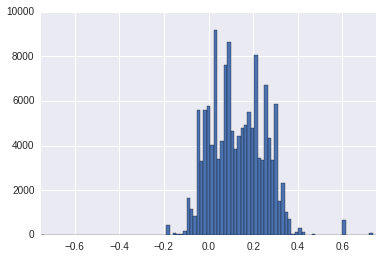

In [33]:
print numpy.percentile(nsim_gls,95)
pylab.hist(nsim_gls,numpy.linspace(-0.75,0.75,100))
pylab.xlim(-0.75,0.75)

0.287002297671


(-0.75, 0.75)

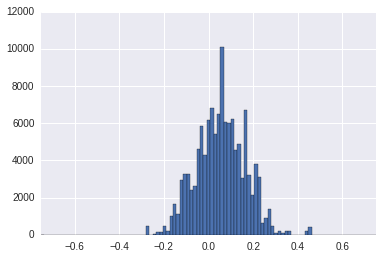

In [38]:
print numpy.percentile(nsim_els,95)
pylab.hist(nnsim_els,numpy.linspace(-0.75,0.75,100))
pylab.xlim(-0.75,0.75)

In [35]:
from wordcloud import WordCloud
g_set=set()
e_set=set()
g_text=''
e_text=''
te_text=''
tg_text=''
for gs in g_scores[:5000]:
    g_set |= {gs[1]}
    g_text += ' ' + ' '.join(gnames[gs[1]])+' '
    #tg_text += ' ' + ' '.join(tnames[gs[1]])+ ' '
for es in e_scores[:5000]:
    e_set|= {es[1]}
    #te_text += ' ' + ' '.join(tnames[es[1]]) + ' '
    e_text += ' ' + ' '.join(enames[es[1]]) + ' '
#g_text = ' '.join(g_set)
#e_text = ' '.join(e_set)
print len(g_set),len(e_set)
print len(g_text),len(e_text),len(tg_text),len(te_text)
len(g_set | e_set)
print e_text.split(' ')

5000 5000
110165 166339 0 0
['', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', '', 'geeky', 'knitters', 'mondays', 'otherworlds', ''

(-0.5, 399.5, 199.5, -0.5)

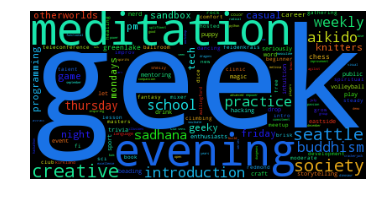

In [36]:
wordcloud = WordCloud().generate(e_text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud)
plt.axis("off")
#pylab.savefig('NerdMinusPersonGroupWords-1k.png')

In [ ]:
print gnames[169999],query_results['group_name'][169999]

In [ ]:
dictionary = corpora.Dictionary.load('Meetup-Fixdict.dict')
corpus = corpora.MmCorpus('Meetup-Fixcorpus.mm')

In [ ]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=2)


In [ ]:
print len(corpus),len(dictionary)

In [ ]:
v_freqs = []
v_freqs_g1 = []
v_freqs_g3 = []
v_freqs_g10 = []
v_freqs_g20 = []
for tokenid, docfreq in dictionary.dfs.iteritems():
    #print docfreq
    v_freqs.append(docfreq)
    #if(docfreq<=3):
    #    print 'Feq',dictionary[tokenid]
    #if(docfreq>3 and docfreq<5):
        #print 'Fairly Few',dictionary[tokenid]
    if(docfreq>1):
        v_freqs_g1.append(docfreq)
    if(docfreq>3):
        v_freqs_g3.append(docfreq)   
    if(docfreq>10):
        v_freqs_g10.append(docfreq)
    #if(docfreq>1442):
       # print 'Many',docfreq,dictionary[tokenid]
        v_freqs_g20.append(docfreq)
print numpy.percentile(v_freqs,99),numpy.percentile(v_freqs,1)
print float(len(v_freqs))/float(len(dictionary))
print float(len(v_freqs_g1))/float(len(dictionary))
print float(len(v_freqs_g3))/float(len(dictionary))
print float(len(v_freqs_g10))/float(len(dictionary))
print float(len(v_freqs_g20))/float(len(dictionary))
avg_freq = sum(v_freqs)/len(v_freqs)
pylab.hist(v_freqs,histtype='step',bins=numpy.linspace(0,2*avg_freq,200),lw=2,weights=(1/len(v_freqs))*numpy.ones(len(v_freqs)))
pylab.xlabel('Word Frequency in Event Names')
pylab.ylabel('Fraction of Words')
#pylab.savefig('EventNameFrequency.png')

In [ ]:
#index = similarities.MatrixSimilarity(lsi[corpus])

#doc = "games"
#vec_bow = dictionary.doc2bow(doc.lower().split())
#vec_lsi = lsi[vec_bow]
#sims = index[vec_lsi]

In [ ]:
index.save('Meetup-MixFix.index')
lsi.save('Meetup-MixFix.lsi')

In [ ]:
index = similarities.MatrixSimilarity.load('Meetup-MixFix.index')
doc = "games"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]
sims = index[vec_lsi]

In [ ]:
print len(sims)
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print sims

In [ ]:
print nsim_tls[:20],nsim_gls[:20],nsim_els[:20]

In [ ]:
#Test that I can do things with the values that I expect to be able to do
sql_query = """
SELECT * FROM search_table;
"""
nerdscore_from_table = pd.read_sql_query(sql_query,con)
#print 3*nerdscore_from_table[nerdscore_from_table<0][:2],3*nerdscore_from_table[nerdscore_from_table>0][:2]
nerd_dist = numpy.array(nerdscore_from_table["nerd_score"])

max_dist = max(nerd_dist)
avg_dist = sum(nerd_dist)/len(nerd_dist)
print 'Avg',avg_dist,'Max',max_dist

print 'Events:',len(nerd_dist)
up_bound = numpy.percentile(nerd_dist,97.5)
mid_bound = numpy.percentile(nerd_dist,95)
n_bound = numpy.percentile(nerd_dist,84)
print mid_bound
low_bound = numpy.percentile(nerd_dist,2.5)
nerd_dist = nerd_dist[(nerd_dist<up_bound)]
print 'Events:',len(nerd_dist)
max_dist = max(nerd_dist)
avg_dist = sum(nerd_dist)/len(nerd_dist)
print 'Avg',avg_dist,'Max',max_dist
pylab.hist(nerd_dist,numpy.linspace(-up_bound,up_bound,20),histtype='step',lw='2',weights=(1/len(nerd_dist))*numpy.ones(len(nerd_dist)))
pylab.axvline(x=avg_dist,color='k',lw='2',label='Avg=%.2f' % avg_dist)
pylab.axvline(x=n_bound,color='g',lw='2',label=r'84%s =%.2f' % ('%',n_bound))
pylab.xlabel("Nerd Score",fontsize=15)
pylab.ylabel("Fraction of Total Events",fontsize=15)
pylab.xlim(-up_bound,up_bound)
pylab.legend(fontsize=15,loc=2)
print time.time()
pylab.tight_layout()
#pylab.savefig("MeetupNerdScores.png")

In [ ]:

sql_query = """
SELECT date FROM event_table;
"""
date_from_table = pd.read_sql_query(sql_query,con)
#print date_from_table['date'][0][1:5],date_from_table['date'][0][6:8],date_from_table['date'][0][9:11]
evt_time = [str(i).strip() for i in date_from_table['date']]
print evt_time[:10]
time_tostr = '%Y-%m-%d'
epoch_time = numpy.array([time.mktime(time.strptime(i, time_tostr)) for i in evt_time])
print epoch_time[:10]

sql_query = """
SELECT time,evt_id FROM event_table;
"""
time_from_table = pd.read_sql_query(sql_query,con)
#print time_from_table['time'][0][1:3],time_from_table['time'][0][4:6]
hours = numpy.array([int(i[1:3]) for i in time_from_table['time']])
minutes = numpy.array([int(i[4:6]) for i in time_from_table['time']])
print hours[:10],minutes[:10]
epoch_time = epoch_time+3600*hours+60*minutes
epoch_time.sort()
print (numpy.array(epoch_time[:10])-time.time())/(3600*24)
fig = pylab.figure(figsize=(5,4))
time_dist = numpy.array([(i-time.time())/(3600*24) for i in epoch_time])
max_dist = max(time_dist)
avg_dist = sum(time_dist)/len(time_dist)
print 'Avg',avg_dist,'Max',max_dist

print 'Events:',len(time_dist)
up_bound = numpy.percentile(time_dist,97.5)
mid_bound = numpy.percentile(time_dist,95)
print mid_bound
low_bound = numpy.percentile(time_dist,2.5)
time_dist = time_dist[(time_dist<up_bound)]
print 'Events:',len(time_dist)
max_dist = max(time_dist)
avg_dist = sum(time_dist)/len(time_dist)
print 'Avg',avg_dist,'Max',max_dist
pylab.hist(time_dist,numpy.linspace(0,up_bound,20),histtype='step',lw='2',weights=(1/len(time_dist))*numpy.ones(len(time_dist)))
pylab.axvline(x=avg_dist,color='k',lw='2',label='Avg=%.2f' % avg_dist)
pylab.xlabel("Time from 6/16/2016 (days)",fontsize=15)
pylab.ylabel("Fraction of Total Events",fontsize=15)
pylab.xlim(0,up_bound)
pylab.legend(fontsize=15)
print time.time()
pylab.tight_layout()
#pylab.savefig("MeetupTimes.png")

In [ ]:
sql_query = """
SELECT fee,evt_id FROM newevent_table;
"""
fee_from_table = pd.read_sql_query(sql_query,con)
fee_dist = numpy.array(fee_from_table["fee"])
max_dist = max(fee_dist)
avg_dist = sum(fee_dist)/len(fee_dist)
print 'Avg',avg_dist,'Max',max_dist

print 'Events:',len(fee_dist)
up_bound = numpy.percentile(fee_dist,97.5)
mid_bound = numpy.percentile(fee_dist,95)
print mid_bound
low_bound = numpy.percentile(fee_dist,2.5)
fee_dist = fee_dist[(fee_dist<up_bound)]
print 'Events:',len(fee_dist)
max_dist = max(fee_dist)
avg_dist = sum(fee_dist)/len(fee_dist)
print 'Avg',avg_dist,'Max',max_dist
pylab.hist(fee_dist,numpy.linspace(0,up_bound,10),histtype='step',lw='2',weights=(1/len(fee_dist))*numpy.ones(len(fee_dist)))
pylab.axvline(x=avg_dist,color='k',lw='2',label='Avg=%.2f' % avg_dist)
pylab.xlabel("Cost ($)",fontsize=15)
pylab.ylabel("Fraction of Total Events",fontsize=15)
pylab.xlim(0,up_bound)
pylab.legend(fontsize=15)
print time.time()
pylab.tight_layout()
#pylab.savefig("MeetupFees.png")

In [ ]:
sql_query = """
SELECT evt_url,evt_id FROM newevent_table;
"""
url_from_table = pd.read_sql_query(sql_query,con)
print url_from_table["evt_url"][0]

In [ ]:


sql_query = """
SELECT lat,evt_id FROM newevent_table;
"""
lat_from_table = pd.read_sql_query(sql_query,con)
print 3*lat_from_table["lat"][:2],lat_from_table["lat"][lat_from_table["lat"]<0][:2]

sql_query = """
SELECT lon,evt_id FROM newevent_table;
"""
in_loc = geolocator.geocode("Seattle, WA")
in_latlong = (in_loc.latitude,in_loc.longitude)
print 'LatLon',in_loc.latitude,in_loc.longitude,in_loc
lon_from_table = pd.read_sql_query(sql_query,con)
print 3*lon_from_table["lon"][:2],lon_from_table["lon"][lon_from_table["lon"]<0][:2]
latlontups = zip(lat_from_table["lat"],lon_from_table["lon"])
dists = [vincenty(in_latlong, i).kilometers for i in latlontups]

print dists[:10]
max_dist = max(dists)
avg_dist = sum(dists)/len(dists)
dists = numpy.array(dists)

print 'Avg',avg_dist,'Max',max_dist

print 'Events:',len(dists)
up_bound = numpy.percentile(dists,97.5)
mid_bound = numpy.percentile(dists,95)
print mid_bound
low_bound = numpy.percentile(dists,2.5)
dists = dists[(dists<up_bound)]
print 'Events:',len(dists)
max_dist = max(dists)
avg_dist = sum(dists)/len(dists)
print 'Avg',avg_dist,'Max',max_dist
fig = pylab.figure(figsize=(6,5))
pylab.hist(dists,bins=numpy.linspace(0,mid_bound,20),lw='2',histtype='step',weights=(1/len(dists))*numpy.ones(len(dists)))
pylab.axvline(x=avg_dist,color='k',lw='2',label='Avg=%.2f' % avg_dist)
pylab.xlim(0,mid_bound)
pylab.xlabel('Distance from Seattle, WA (km)',fontsize=15)
pylab.ylabel('Fraction of Total Events',fontsize=15)
pylab.legend(fontsize=15)
#print address[:10]
pylab.tight_layout()
#pylab.savefig("MeetupDistances.png")